In [1]:
# Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model and performance evaluation
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

#add explainable AI libraries
import shap
initjs = shap.initjs()
from sklearn.inspection import partial_dependence,PartialDependenceDisplay
import pycebox.ice as pice

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# import the data
data = pd.read_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/final.csv')

In [3]:
data.shape

(1315, 2515)

In [4]:
# set the feature and target variable
X = data.drop(columns='outcome')
y = data.outcome

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [5]:
y.value_counts(normalize=True)

outcome
0.0    0.696578
1.0    0.303422
Name: proportion, dtype: float64

###  Before executing grid search alogrithms, a benchmark model has to be fitted

In [6]:
# Initiate XGBoost Classifier
xgbc0 = XGBClassifier()

# Print default setting
xgbc0.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [7]:
# Train the model
xgbc0 = XGBClassifier(seed=0).fit(X_train, y_train)

# Make prediction
xgbc0_predict = xgbc0.predict(X_test)

# Get predicted probability
xgbc0_predict_prob = xgbc0.predict_proba(X_test)

In [8]:
# Get performance metrics
precision, recall, fscore, support = score(y_test, xgbc0_predict)

# Print result
print(f'The recall value for the baseline xgboost model is {recall[1]:.4f}')

The recall value for the baseline xgboost model is 0.2581


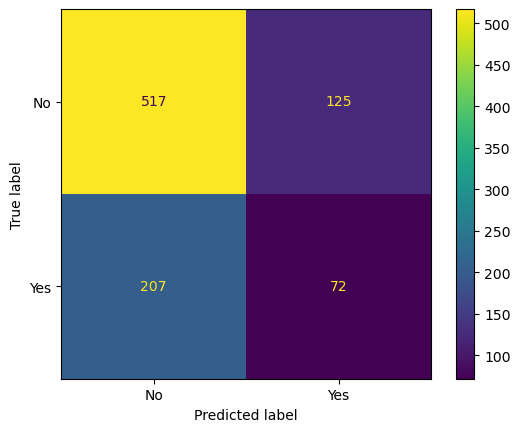

In [9]:
# show confusion matrix display
confusion_matrix = confusion_matrix(y_test, xgbc0_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['No', 'Yes'])
disp.plot();

### We wil now take a brute force approach to grid search to find ideal params to optimize the model
We will keep the grid search space relatively small to finish in a reasonable timeframe 

In [10]:
# Define the search space
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1]
    }
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [11]:
# Define grid search
grid_search = GridSearchCV(estimator=xgbc0, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=8, 
                           cv=kfold, 
                           verbose=5)

# Fit grid search
grid_result = grid_search.fit(X,y)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 3/5] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0; recall: (test=0.237) total time=   3.7s
[CV 2/5] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0; recall: (test=0.225) total time=   3.7s
[CV 1/5] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0; recall: (test=0.200) total time=   3.7s
[CV 1/5] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0.5; recall: (test=0.163) total time=   3.7s
[CV 5/5] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0; recall: (test=0.278) total time=   3.8s
[CV 2/5] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0.5; recall: (test=0.212) total time=   3.7s
[CV 3/5] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0.5; recall: (test=0.200) total time=   3.7s
[CV 4/5] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0; recall: (test=0.225) total time=   3.8s
[CV 5/5] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0.5; recall: (test=0.241) total time=   3.7s
[CV 1/5] END

In [12]:
# Print grid search summary
grid_result

# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print('The best score standard deviation is', round(grid_result.cv_results_['std_test_recall'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')

The best score is 0.2556
The best score standard deviation is 0.0126
The best hyperparameters are {'colsample_bytree': 0.8, 'reg_alpha': 0, 'reg_lambda': 0.5}


In [13]:
# Make prediction using the best model
grid_predict = grid_search.predict(X)

# Get predicted probabilities
grid_predict_prob = grid_search.predict_proba(X)[:,1]

# Get performance metrics
precision, recall, fscore, support = score(y, grid_predict)

# Print result
print(f'The recall value for the xgboost grid search is {recall[1]:.4f}')

The recall value for the xgboost grid search is 0.6491


### Random Search for XGBoost
In step 7, we are using a random search for XGBoost hyperparameter tuning. Since random search randomly picks a fixed number of hyperparameter combinations, we can afford to try more hyperparameters and more values. Therefore, we added three more parameters to the search space.

In [14]:
# Define the search space
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [15]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgbc0, 
                           param_distributions=param_grid, 
                           n_iter=48,
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=8, 
                           cv=kfold, 
                           verbose=5)
# Fit grid search
random_result = random_search.fit(X_train, y_train)




Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.0001, max_depth=3, reg_alpha=0.01, reg_lambda=10; recall: (test=0.000) total time=   1.2s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.0001, max_depth=3, reg_alpha=0.01, reg_lambda=10; recall: (test=0.000) total time=   1.3s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.0001, max_depth=3, reg_alpha=0.01, reg_lambda=10; recall: (test=0.000) total time=   1.3s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.0001, max_depth=3, reg_alpha=10, reg_lambda=100; recall: (test=0.000) total time=   1.7s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.0001, max_depth=3, reg_alpha=10, reg_lambda=100; recall: (test=0.000) total time=   1.7s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.0001, max_depth=3, reg_alpha=10, reg_lambda=100; recall: (test=0.000) total time=   1.8s
[CV 1/5] END colsample_bytree

In [16]:
# Print grid search summary
random_result
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

The best score is 0.3167
The best score standard deviation is 0.0773
The best hyperparameters are {'reg_lambda': 1e-05, 'reg_alpha': 0.1, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.1, 'colsample_bytree': 0.7}


In [17]:
# create variables for each of the best hyperparameters
best_learning_rate = random_result.best_params_['learning_rate']
best_max_depth = random_result.best_params_['max_depth']
best_gamma = random_result.best_params_['gamma']
best_colsample_bytree = random_result.best_params_['colsample_bytree']
best_reg_alpha = random_result.best_params_['reg_alpha']
best_reg_lambda = random_result.best_params_['reg_lambda']


In [18]:
# Make prediction using the best model
random_predict = random_search.predict(X_train)

# Get predicted probabilities
random_predict_prob = random_search.predict_proba(X_train)[:,1]

# Get performance metrics
precision, recall, fscore, support = score(y_train, random_predict)

# Print result
print(f'The recall value for the xgboost random search is {recall[1]:.4f}')

The recall value for the xgboost random search is 0.8833


In [19]:
# Initiate XGBoost Classifier, fit with best parameters from random 
xgbc1 = XGBClassifier(
    learning_rate = best_learning_rate,
    max_depth = best_max_depth,
    gamma = best_gamma,
    colsample_bytree = best_colsample_bytree,
    reg_alpha = best_reg_alpha,
    reg_lambda = best_reg_lambda,
    seed=0).fit(X_train,y_train)

# Make prediction
xgbc1_predict = xgbc1.predict(X_test)

# Get predicted probability
xgbc1_predict_prob = xgbc1.predict_proba(X_test)[:,1]

# Get performance metrics
precision, recall, fscore, support = score(y_test, xgbc1_predict)

# Print result
print(f'The recall value for the xgboost optimization is {recall[1]:.4f}')

The recall value for the xgboost optimization is 0.3333


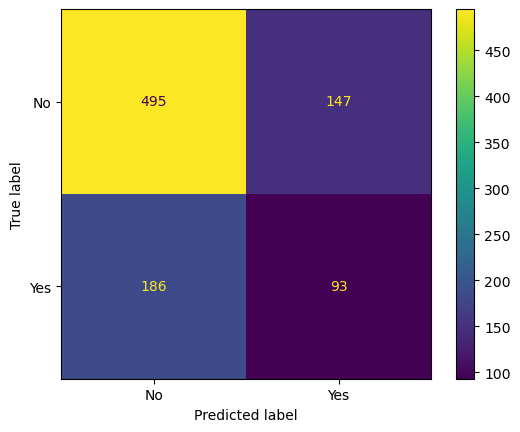

In [20]:
# show confusion matrix display (rebind new object)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, xgbc1_predict)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['No', 'Yes'])

disp.plot();

Bayesian Optimization For XGBoost
In step 8, we will apply Hyperopt Bayesian optimization on XGBoost hyperparameter tuning. According to the documentation on Hyperopt github page, there are four key elements for Hyperopt:<br>

the space over which to search<br>
the objective function to minimize<br>
the database in which to store all the point evaluations of the search<br>
the search algorithm to use<br>

In [ ]:
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

In [ ]:
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
# Objective function
def objective(params):
    
    xgboost = XGBClassifier(seed=0, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train, 
                            y=y_train, 
                            cv=kfold, 
                            scoring='recall', 
                            n_jobs=-1).mean()
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}


## This coming section covers tools for Explainable AI (xAI).  Tools and methods used for model interpretation.

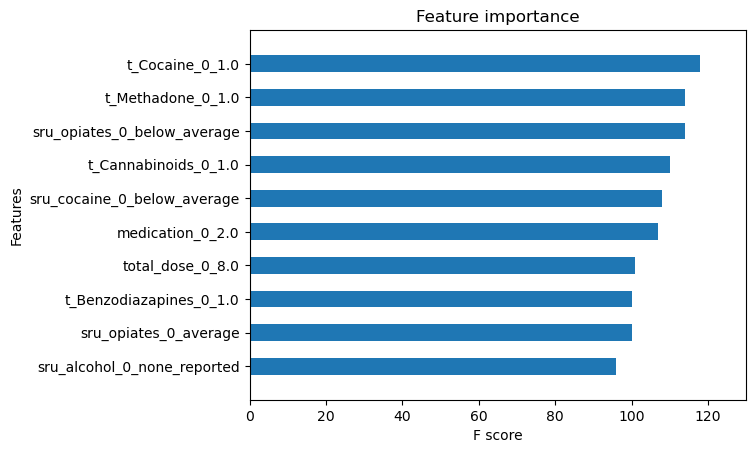

In [22]:
# plot feature importance from xboost
import xgboost
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(xgbc1, max_num_features=10, 
                     show_values=False,
                     height=0.5,
                     xlim=None,
                     ylim=None,
                     title='Feature importance',
                     xlabel='F score',
                     ylabel='Features',
                     grid=False);

In [23]:
explainer = shap.TreeExplainer(xgbc1)
shap_values = explainer.shap_values(X)

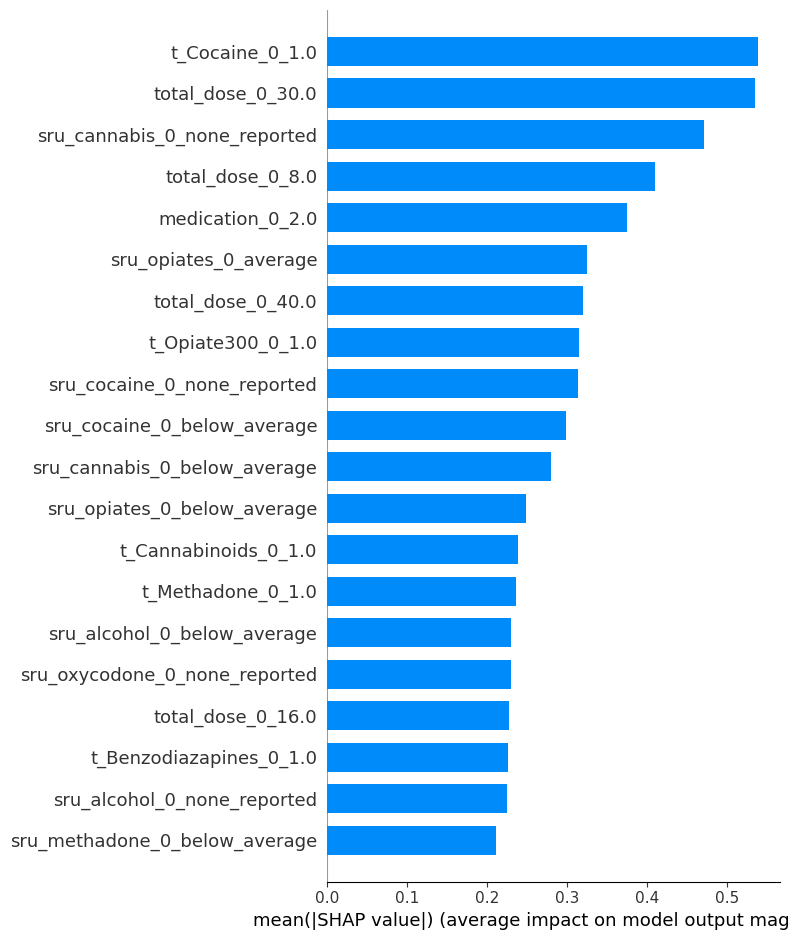

In [24]:
shap.summary_plot(shap_values, X, 
                  plot_type="bar",  
                  max_display=20,
                  )

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


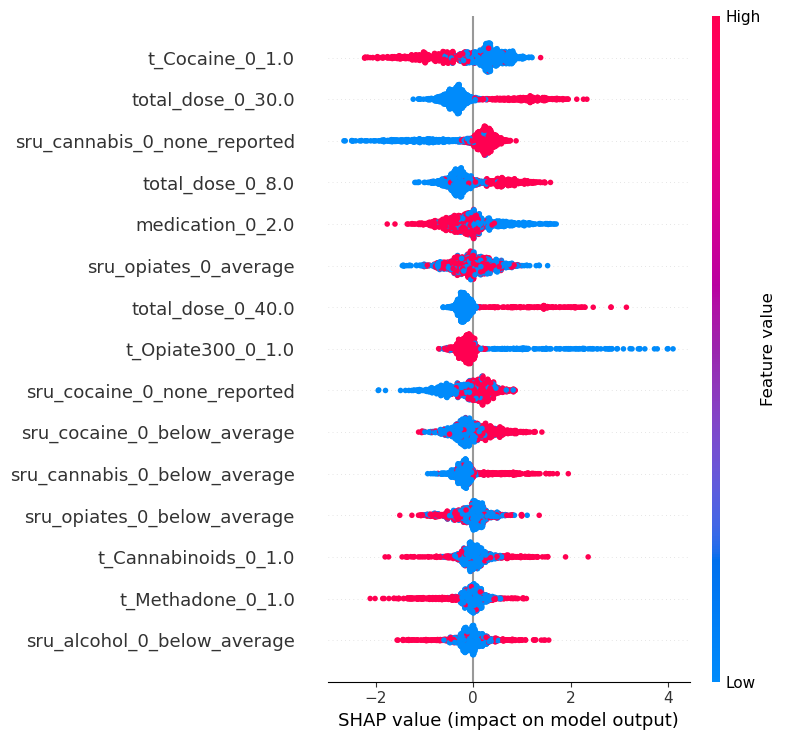

In [25]:
shap.summary_plot(shap_values, X, 
                  max_display=15,
                  );

In [ ]:
explainer = shap.Explainer(xgbc1)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
explainer = shap.Explainer(xgbc1)
shap_values = explainer(X)

shap.plots.bar(shap_values)

In [ ]:
# create partial dependence plot
features = []
fig, ax = plt.subplots(figsize=(10,5))
PartialDependenceDisplay.from_estimator(xgbc1, X_train, features=features, ax=ax);


In [ ]:
# create individual conditional expectation plot
ice_df = pice.ice(data=X_train, column='t_Cocaine', 
                   predict=xgbc1_predict)